# Model Evaluation

In [2]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
# Load pre-split data
def load_split_data(path):
    df = pd.read_csv(path)
    X = df.drop(columns=['puffs'])  
    y = df['puffs']                 
    return X, y

# Load all splits
X_train, y_train = load_split_data("../data/processed/splits/train_data.csv")
X_val, y_val = load_split_data("../data/processed/splits/val_data.csv") 
X_test, y_test = load_split_data("../data/processed/splits/test_data.csv")

# Load model
model_path = f"../model/production/xgb_hyp20250302-1821_mae_0.5.pkl"
model = joblib.load(model_path)

# Fit model
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-mae:0.75875	validation_0-rmse:1.01968
[1]	validation_0-mae:0.73027	validation_0-rmse:0.98590
[2]	validation_0-mae:0.71410	validation_0-rmse:0.96697
[3]	validation_0-mae:0.70026	validation_0-rmse:0.95097
[4]	validation_0-mae:0.68829	validation_0-rmse:0.93786
[5]	validation_0-mae:0.67873	validation_0-rmse:0.92748
[6]	validation_0-mae:0.66170	validation_0-rmse:0.90664
[7]	validation_0-mae:0.64680	validation_0-rmse:0.88891
[8]	validation_0-mae:0.63971	validation_0-rmse:0.88125
[9]	validation_0-mae:0.63356	validation_0-rmse:0.87489
[10]	validation_0-mae:0.62750	validation_0-rmse:0.86866
[11]	validation_0-mae:0.62180	validation_0-rmse:0.86289
[12]	validation_0-mae:0.61228	validation_0-rmse:0.85249
[13]	validation_0-mae:0.60399	validation_0-rmse:0.84334
[14]	validation_0-mae:0.59676	validation_0-rmse:0.83521
[15]	validation_0-mae:0.59024	validation_0-rmse:0.82848
[16]	validation_0-mae:0.58436	validation_0-rmse:0.82265
[17]	validation_0-mae:0.57905	validation_0-rmse:0.81819
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09400123577853053, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=271, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Model Performance Metrics:
        MAE      RMSE        R²  Error Std  Max Error
0  0.528143  0.786579  0.443645   0.786578   8.322579

Clinical Impact Metrics:
                                    confusion_matrix  sensitivity  \
0  pred_risk  High Risk  Normal
true_risk        ...     0.463157   

   specificity  clinical_accuracy  
0     0.967219           0.935026  


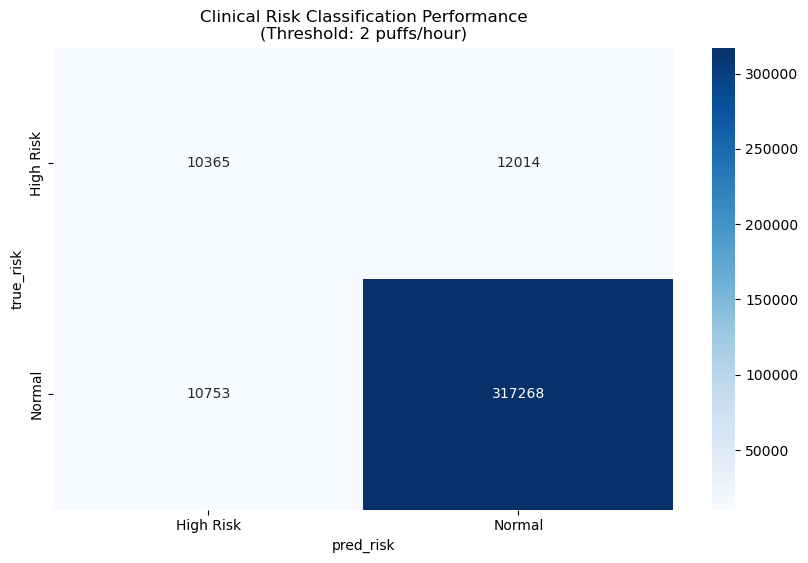

In [9]:
# 1. Core Performance Metrics
def calculate_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'Error Std': np.std(y_true - y_pred),
        'Max Error': np.max(np.abs(y_true - y_pred))
    }

# Generate predictions
test_preds = model.predict(X_test)

# Calculate metrics
metrics = calculate_metrics(y_test, test_preds)
print("Model Performance Metrics:")
print(pd.DataFrame([metrics]))

# 2. Clinical Impact Analysis (Updated for DataFrame Input)
def clinical_error_analysis(df):
    # Critical thresholds (GEMA guidelines)
    df['true_risk'] = np.where(df['true'] > 2, 'High Risk', 'Normal')
    df['pred_risk'] = np.where(df['pred'] > 2, 'High Risk', 'Normal')
    
    confusion = pd.crosstab(df['true_risk'], df['pred_risk'])
    
    sensitivity = confusion.loc['High Risk', 'High Risk']/confusion.loc['High Risk'].sum()
    specificity = confusion.loc['Normal', 'Normal']/confusion.loc['Normal'].sum()
    
    return {
        'confusion_matrix': confusion,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'clinical_accuracy': (confusion.values.diagonal().sum()/confusion.values.sum())
    }

# Prepare error analysis dataframe
error_df = X_test.copy()
error_df['true'] = y_test.values
error_df['pred'] = test_preds

# Generate clinical metrics
clinical_metrics = clinical_error_analysis(error_df)
print("\nClinical Impact Metrics:")
print(pd.DataFrame([clinical_metrics]))

# Visualization code remains the same (SHAP, temporal/spatial plots, business impact)
plt.figure(figsize=(10,6))
sns.heatmap(clinical_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Clinical Risk Classification Performance\n(Threshold: 2 puffs/hour)')
plt.savefig('clinical_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_52575/2418971124.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=time_col, y='error', data=df,
/tmp/ipykernel_52575/2418971124.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ivanseldasp/anaconda3/envs/asthma-realtime-py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


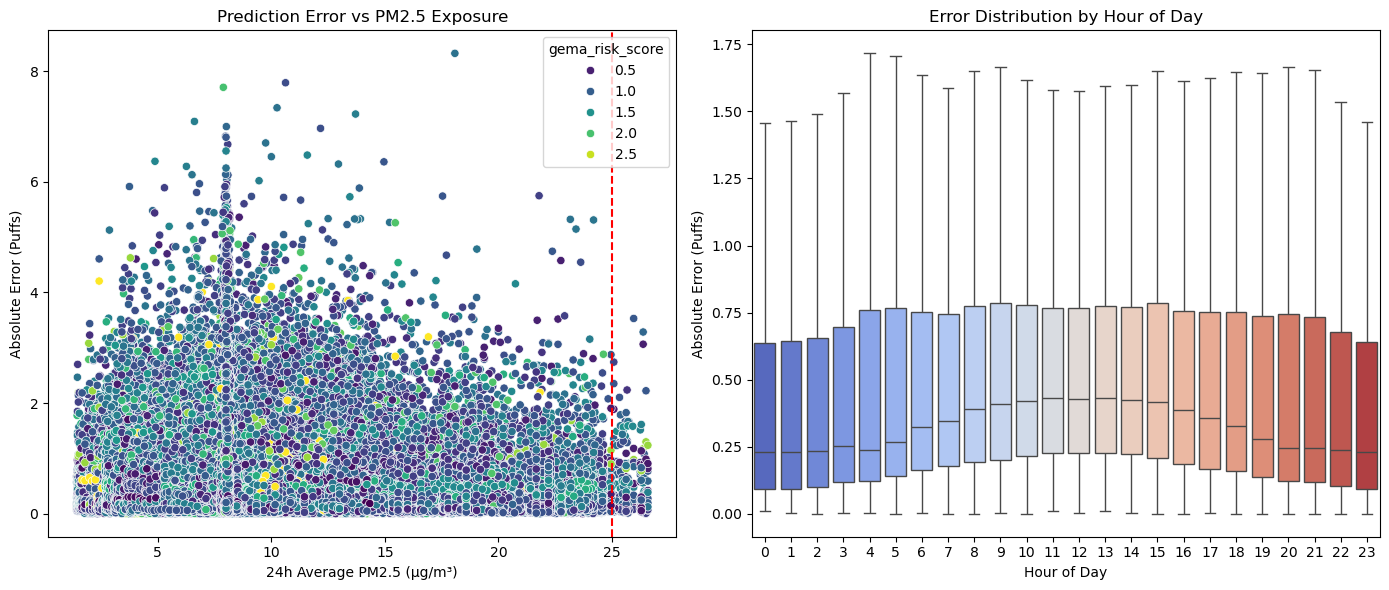

KeyError: 'district'

In [10]:
# 3. SHAP Analysis for Clinical Interpretability
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_train, plot_type='bar', show=False)
plt.title('Feature Impact on Inhaler Usage Predictions')
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Temporal Error Analysis
def plot_temporal_errors(df, time_col='hour'):
    df['error'] = np.abs(df['true'] - df['pred'])
    
    plt.figure(figsize=(14,6))
    
    # Pollution vs Error
    plt.subplot(1,2,1)
    sns.scatterplot(x='pm25_24h_avg', y='error', data=df,
                   hue='gema_risk_score', palette='viridis')
    plt.axvline(25, color='r', linestyle='--', label='WHO PM2.5 Limit')
    plt.title('Prediction Error vs PM2.5 Exposure')
    plt.xlabel('24h Average PM2.5 (µg/m³)')
    plt.ylabel('Absolute Error (Puffs)')
    
    # Time-of-Day Pattern
    plt.subplot(1,2,2)
    sns.boxplot(x=time_col, y='error', data=df,
               showfliers=False, palette='coolwarm')
    plt.title('Error Distribution by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Absolute Error (Puffs)')
    
    plt.tight_layout()
    plt.savefig('temporal_errors.png', dpi=300)
    plt.show()

error_df = X_test.copy()
error_df['true'] = y_test.values
error_df['pred'] = model.predict(X_test)
plot_temporal_errors(error_df)

# 5. Spatial Error Analysis
def plot_spatial_errors(df):
    district_errors = df.groupby('district').agg({
        'error': 'mean',
        'pm25_24h_avg': 'mean',
        'gema_risk_score': 'mean'
    }).sort_values('error', ascending=False)
    
    plt.figure(figsize=(12,6))
    sns.heatmap(district_errors.T, annot=True, fmt=".1f",
               cmap="YlOrRd", linewidths=.5)
    plt.title('Spatial Error Analysis by District')
    plt.xlabel('District')
    plt.ylabel('Metrics')
    plt.savefig('spatial_errors.png', dpi=300)
    plt.show()

plot_spatial_errors(error_df)

# 6. Business Impact Projection
def calculate_business_impact(y_true, y_pred):
    # Preventable exacerbations (assuming 10 puffs/day = 1 exacerbation)
    preventable = np.sum((y_true >= 10) & (y_pred >= 8)) / np.sum(y_true >= 10)
    
    # Cost savings (simulated)
    hospital_cost = 5000  # USD per exacerbation
    daily_patients = 1000
    savings = preventable * daily_patients * hospital_cost * 0.3  # 30% prevention
    
    return {
        'preventable_exacerbations': f"{preventable*100:.1f}%",
        'estimated_daily_savings': f"${savings:,.0f}"
    }

impact = calculate_business_impact(y_test, model.predict(X_test))
print("\nBusiness Impact:")
print(impact)